## PD结合的思路

### 分别替换gate/up层

先输入一句话，按照70%稀疏去记录prefill阶段激活的神经元，最后统计这个输入prompt对应的最高激活次数的70%的神经元。

In [1]:
import os
import json
import torch
from transformers import LlamaForCausalLM, AutoTokenizer
from transformers import GenerationConfig
from datasets import load_dataset

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### from path.json read paths of model and dataset
model_name = "Llama3-8b"
dataset_name = "c4"
with open('path.json', 'r') as file:
    paths = json.load(file)
    model_path = paths.get(model_name, '')
    dataset_path = paths.get(dataset_name, '')

c4 = load_dataset(dataset_path)
model = LlamaForCausalLM.from_pretrained(
    model_path,
    device_map='auto',
    use_cache=True,
    torch_dtype=torch.float16,
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
from tqdm import tqdm
import convert_llama
# for gamma in [0,0.2]:
#     for beta in [0,0.2]:
SAMPLE_NUM = 2000
MAX_LENGTH = 300
OUTPUT_LENTGH = 1
alpha = 0.2
# for gamma,beta in [(0,0.3),(0.3,0),(0.2,0.2)]:
for gamma, beta in [(0.3,0.1)]:
# for gamma, beta in [(0,0.1)]:
# for gamma, beta in [(0.3221,0)]:
# for gamma,beta in [(0.1,0.2),(0.2,0.1),(0.2,0.2)]:
    print(f"alpha: {alpha}, gamma: {gamma}, beta: {beta}")
    convert_llama.convert_llama_model(model, sparsity=0.1, start_num=21, end_num=32, alpha=alpha, beta=beta, gamma=gamma, use_core=False)
    # for layerid in range(22,32):
    #     model.model.layers[layerid].mlp.clear_list()

    # for c4_demo in c4['validation']['text'][:SAMPLE_NUM]:
    for c4_demo in tqdm(c4['validation']['text'][:SAMPLE_NUM]):
        input_demo = tokenizer(c4_demo, padding=False, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
        if input_demo.input_ids.shape[1] < MAX_LENGTH:
            continue
        # print(tokenizer.batch_decode(input_demo.input_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0])
        generate_ids = model.generate(input_demo.input_ids.to('cuda:0'), max_length=MAX_LENGTH+OUTPUT_LENTGH, generation_config=GenerationConfig(do_sample=False), pad_token_id=tokenizer.eos_token_id)
        # tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        # print(tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0])
    for layerid in range(22,32):
        model.model.layers[layerid].mlp.print_ratio()


alpha: 0.2, gamma: 0.3, beta: 0.1


Convert Llama Models: 432it [00:00, 10135.59it/s]

Converted Model Done



  0%|          | 0/2000 [00:00<?, ?it/s]

The woman who died after falling from a bridge over the A21 has been identified as a Sevenoaks mum.
Marta Kendle, 37, fell from the Gracious Lane bridge on the morning of February 19.
Police were called to the carriageway around 6.10am and the road was promptly closed in both directions.
Despite paramedics best efforts, Marta, who was originally from Poland, was pronounced dead at the scene.
Kent and Medway Coroners office have confirmed an inquest into her death will open on Wednesday (February 27).
Tributes to the mum were left at the scene and on social media.
Friend, Jodi Cahill posted on Facebook: "I will certainly remember you. I am sorry we did not see how lost and alone you felt.
"Be at peace dear Marta."
A floral tribute left at the scene said goodbye to the "beautiful and kind soul".
It read: "To a beautiful and kind soul, we are sorry we didn&apos;t see your pain. We will miss you always.
"Rest in peace Marta, Love from Lorraine, Colin and family."
The inquest will take plac

  0%|          | 2/2000 [00:01<19:47,  1.68it/s]

The woman who died after falling from a bridge over the A21 has been identified as a Sevenoaks mum.
Marta Kendle, 37, fell from the Gracious Lane bridge on the morning of February 19.
Police were called to the carriageway around 6.10am and the road was promptly closed in both directions.
Despite paramedics best efforts, Marta, who was originally from Poland, was pronounced dead at the scene.
Kent and Medway Coroners office have confirmed an inquest into her death will open on Wednesday (February 27).
Tributes to the mum were left at the scene and on social media.
Friend, Jodi Cahill posted on Facebook: "I will certainly remember you. I am sorry we did not see how lost and alone you felt.
"Be at peace dear Marta."
A floral tribute left at the scene said goodbye to the "beautiful and kind soul".
It read: "To a beautiful and kind soul, we are sorry we didn&apos;t see your pain. We will miss you always.
"Rest in peace Marta, Love from Lorraine, Colin and family."
The inquest will take plac

  0%|          | 10/2000 [00:01<02:45, 12.01it/s]

CHARLES H. MEISNER, one of the prosperous and highly-esteemed business men of Birnamwood, Shawano county, was born in Newton township, Manitowoc Co., Wis., February 14, 1860, and is a son of Frederick and Magarette (Steltzer) Meisner, both natives of Germany.
Frederick Meisner was born February 5, 1825, in Mechlenburg, Germany, and after the death of his father he, with his mother and the rest of the family, came to America in 1849, settling in Manitowoc county. Here the mother lived to the good old age, dying in 1888. The parental family comprised six children, namely John, Frederick, Joseph, Dora, Josephine and Mary. The mother of our subject was born in Bavaria about the year 1832. Her mother died in Germany, and about 1850 she came to America with her father and her three brothers; John, William and Nicholas—and three sisters—Mary, Cathrena and Lena. Her father was a farmer by occupation. Frederick Meisner had six children of whom Charles H., Frederick J. and Henry are living; Will

  1%|          | 17/2000 [00:02<02:25, 13.65it/s]

Stately palm trees reach to the blue sky.
The city of Split, and majestic mountains, far off in the distance.
Looking up from Trogir’s network of little streets.
Cheery lemons await picking, or just admirers.
A tiny church, off in the distance.
Silhouette of Kairos (the god of the fleeting moment), modeled after a 3rd-century bas-relief found in the town.
These are beautiful. Lucky you!
Lucky indeed, Caitlin. When we walk out among the buildings adorned with coats of arms, strolling the city’s labyrinthine lanes, I have to pinch myself that I’ve been in such a special city for over a month. The friendly people here make Trogir all the more wonderful.
Jen, I agree with you that perpetually sunny skies can get a bit overwhelming. I felt the same way this past fall, visiting sunny Nevada. Sometimes I just yearned for a rain cloud or two. I suppose the “grass is always greener.” I liked your line that once again the “blue skies hold magic” for you.
Some great looking up shots, Tricia. Love

  1%|          | 20/2000 [00:02<02:32, 13.03it/s]

You can rely on Sure Betbuilder S to present the very best service when it comes to Builder in Mc Leansville, NC. You'll need the most sophisticated technologies around, and our workforce of skilled experts will give you just that. Our materials are always of the very best quality and we are able to save cash. We can help you to come up with decisions for your job, answer all your questions, and organize a meeting with our professionals whenever you contact us by dialing 888-459-0005.
Why's Us The Best ?
Sure Betbuilder S concentrates on customer satisfaction to guarantee that you are happy with our labor. We discover your objectives and project standards, and we're going to strive to make certain you approve of our results. We understand all of your concerns, and we are ready to help. If you contact us today, we will answer your questions and concerns, and we will actually resolve the important questions which you did not think to ask. You should put together the best decisions for yo

  1%|          | 24/2000 [00:02<02:21, 13.99it/s]

Drinking is sometimes very fascinating especially as you hang out with friends; it is a fun and provides the feeling of well being. However, the odor of alcohol is annoying for the family and co-workers around you at the workplace especially if you are Smelling like alcohol the next day. Drinking alcohol results in a strong odor around you and as soon as you realize it, you will try to get rid of its smell. Also the alcoholic breath is highly unpleasant for the people around you. In this article we will learn some How to get rid of alcohol breath home remedies?
2 How to Get Rid of Alcohol Odor Naturally?
The strong smell of alcohol is always one of the serious concerns of the drinkers. Also in the life time, some people drink heavily and they are unaware of the unpleasant smell of alcohol around them. As the alcohol addicts realize that they have strong odor in their breath and body, they need to find some ways to get rid of this unpleasant smell especially as they go to their workplac

  2%|▏         | 30/2000 [00:02<01:46, 18.56it/s]

Thymoquinone protects DRG neurons from axotomy-induced cell death.
OBJECTIVE: Peripheral nerve injury (PNI) is a significant health problem that is linked to sensory, motor, and autonomic deficits. This pathological condition leads to a reduced quality of life in most affected individuals. Schwann cells (SCs) play a crucial role in the repair of PNI. Effective agents that promote SC activation may facilitate and accelerate peripheral nerve repair. Thymoquinone (TQ), a bioactive component of Nigella sativa seeds, has an antioxidant, anti-inflammatory, immunomodulatory, and neuroprotective properties. In the present study, the neuroprotective efficacy of TQ was investigated by using a laser microdissection technique in a mouse PNI model.
METHODS: Single cells were isolated from dorsal root ganglions (DRGs) of 6-8-week-old mice, maintained in defined culture conditions and treated with or without TQ at different concentrations. Axons were cut (axotomy) using a controllable laser microbeam

  2%|▏         | 37/2000 [00:03<01:29, 21.93it/s]

Who am I? What's this all About?
You could say I grew up traveling, when I was young I lived in Lagos, Nigeria with my family. Over the years I spent there we traveled to some of the countries you see highlighted in green. During these travels I saw the pyramids of Egypt, I summited Mt. Kilimanjaro, skied in the alps, learned how to scuba dive in Mauritius, and so much more. I was very lucky in this respect, but living in West Africa exposed me to some stark realities. I quickly came to understand that the world is a harsh place to most people. The struggle for survival is something real and a part of most peoples' everyday lives.
It wasn't until later, that I decided to travel again. This time on my own. At the age of twenty, fed up with the mundane routine of my life, I decided to take some time off school and head south. From my home in Colorado I traveled to Belize, Guatemala, and El Salvador. I was interested in environmental science, ecology, and societies different from my own a

  2%|▏         | 40/2000 [00:03<01:52, 17.47it/s]

Born 1952; Education: Elmira College, B.A.; attended School of Visual Arts, and New School for Social Research.
Offıce—375 South End Ave., #12T, New York, NY 10280.
Writer and illustrator. Dial Press, New York, NY, worked as a design assistant and secretary for two years; owner of freelance illustration business, 1980—.
Lawrence Weinberg, What Is This For?, Little Simon (New York, NY), 1982.
Lawrence Weinberg, The ABC's, Little Simon (New York, NY), 1982.
The City Mouse and the Country Mouse, Grosset & Dunlap (New York, NY), 1985.
The Night before Christmas, Ideals Publishing (Nashville, TN), 1988.
Lyn Sandow, My First Tool Books, Warner (New York, NY), 1988.
Stephanie St. Pierre, Mystery in the Woods, Marvel (New York, NY), 1988.
Sharon Gordon, Home for a Puppy, Troll (Mahwah, NJ), 1988.
Joanne Barkan, My First Kitchen Gadget Books, six volumes, Warner (New York, NY), 1989.
What a Teddy Bear Needs, Ladybird Books (London, England), 1989.
Joanne Barkan, My First Garden Tools, three vol

  2%|▏         | 46/2000 [00:03<01:20, 24.36it/s]

Marketers are employed in the public sector as well as the private sector.
Most people think of marketing as a strictly private sector activity, but the reality is people with sales and marketing backgrounds are hired by government agencies in a number of capacities. Government agencies at the local, state and federal level all employ marketing professionals in areas including, but not limited to, public relations, property disposal, bond sales and purchasing.
Almost all major government agencies have their own public-relations staff, and in many cases it is a stand-alone department with a public relations or media director and several support staff. Government agency PR departments are responsible for producing news releases, holding press conferences, and generally promoting activities of the agency, such as tourism or encouraging new businesses to move into the area.
Government agencies are constantly buying supplies, equipment and other property and selling off old equipment and pr

  3%|▎         | 52/2000 [00:03<01:37, 20.07it/s]

Too much? That's good because we were almost out of card puns for this one. Regardless of the terrible puns, we stand by what we said about fitting in but also being an individual and all that jazz. Which is exactly why we think a playing card its the perfect representational costume of the dichotomy of individualism vs. collectivist natures... and also we really like cards. Throwing them at things, building card castles with them, and playing games with them. Perhaps you have a kid like this. What? No, not a kid posing rhetorical questions about individualism, a kid who likes cards.
If you do have a kid like this, well then we have the perfect outfit for them. Our Kids Ace of Clubs Costume has a white, foam-backed sleeveless tunic designed to look like the ace of clubs. Attached is a black velvet hood and cowl collar, shaped to look like a club, with a zipper up the back. The neck of the hood has elastic around the front edge for a snug fit around the face, and it comes with black vel

  3%|▎         | 66/2000 [00:04<00:58, 32.98it/s]

Η GMC παρουσιάζει την Nightfall έκδοση του Terrain που θα κάνει ντεμπούτο στην έκθεση της Νέας Υόρκης. Το μοντέλο ξεχωρίζει από την μαύρη γρίλια, τα μαύρα γυαλιστερά διακοσμητικά, τις μαύρες ράγες οροφής και τις μαύρες/αλομινένιες ζάντες 18″.
Είναι διαθέσιμο σε τέσσερα εξωτερικά χρώματα (Onyx Black, Crimson Red Metallic, Graphite Gray Metallic και Summit White) και στο εσωτερικό διαθέτει το σύστημα ενημέρωσης και ψυχαγωγίας IntelliLink με οθόνη αφής 7″ και συνδεσιμότητα 4G LTE με Wi-Fi hotspot.
Οι πωλήσεις του θα ξεκινήσουν από το φθινόπωρο.
The News Ahead of its debut at the New York International Auto Show, GMC today introduced the 2017 GMC Terrain Nightfall Edition – a stylized special edition combining blacked-out exterior details and wheels, with popular technologies such as IntelliLink with available 4G LTE connectivity and Wi-Fi hotspot.
It joins the Canyon Nightfall Edition and the all-new Sierra All Terrain X as the latest GMC vehicle to offer an exclusive, personalized appear

  4%|▎         | 70/2000 [00:04<01:15, 25.56it/s]

If you are on the lookout for cost savings, your first thoughts almost certainly relate to product sales, blowouts, and bargains. The best location to discover coupon codes is via on-line suppliers. Buying items on the web can conserve far more income than purchasing from any other income channel. The following article will present you how.
When purchasing on the internet, it is crucial that your spyware and anti-virus computer software is up to date. If your personal computer is infected with something as simple as a keylogger even though producing an on-line purchase, you just handed a stranger your credit rating card number. Shell out focus to the warnings that are provided by your safety software if you see any suspicious exercise, report them to your website’s webmaster.
Take your time and see the costs at many on the web stores to see how items examine on all of the internet sites. Unless of course you really have your heart set on a specific brand name, be open up to distinct po

  4%|▍         | 82/2000 [00:04<00:53, 35.58it/s]

Editor’s note: The Consulate General of Belgium in Atlanta each month puts out a newsletter recounting its activities across the region and informing its compatriots about vital information from the foreign ministry. Follow the consulate on Facebook.
As with each edition, this month’s included a spotlight on Belgian living and working in the consulate’s jurisdiction. Known as “The Belgian in the Picture,” the series aims to show just how deeply impactful the country’s economic and cultural engagement with the South is, despite its small size. The below Q&A is reprinted with permission and has been lightly edited for clarity and style.
Belgian Consulate: Paul De Sloover, a veteran Belgian entrepreneur in the U.S., is being spotlighted in this month’s newsletter — appropriated given that his latest venture provides an innovative way to generate power from the sun. Mr. De Sloover, can you tell us more about the solar roof tiles made by Desol Power Tiles?
Mr. de Sloover: Solar roof tiles a

  4%|▍         | 86/2000 [00:04<00:56, 34.13it/s]

I always love a good nosey into people’s bags – it kind of shows you a little bit more of their personality. This backpack is from Urban Outfitters which I actually picked up in the sale for the bargainous price of £20. I’m not one to carry around a lot of things with me on a daily basis – these are the main things I had. I had just bought the two Models Own nail polish featured above – Boots are currently having a 2 for £8 offer on them, so now is the time to snap some up. I’m looking forward to trying the Hed Kandi collaboration – a have seen it on a few friends nails and it looks fabulous.
I always need some hand cream with me because I hate how dry my hand gets from using cheap soap at work – this works a treat. The superbalm from Liz Earle is really good for lips and any dry patches you might have – it works wonders on elbows! I am loving the new Revlon Lip Butters – I often find lipsticks really drying so this is a perfect solution.
My sheep keyring was from the Mark Fast goodie 

  4%|▍         | 90/2000 [00:05<01:13, 25.98it/s]

Welcome to Boston Mamas Rock! – where we’re giving a voice to fabulous local mamas from all walks of life. Read on for today’s interview with Susan Dorson & Amy Weitzman, two local moms on a mission to save their community library and provide parents with an eco-friendly, affordable shopping option via The Little Fox Shop. Then go ahead and nominate yourself or a friend!
Christine: Welcome, Susan and Amy! You were nominated for this feature because of the work you have done to start The Little Fox Shop at the Edith Fox Branch Library in East Arlington, where all proceeds go to support the library (whose doors have been on the verge of closing for some time due to budget cuts). Now, everyone (present company included) talks about the importance of preserving local libraries, but your efforts truly walk the walk. What inspired you to action to help save the Fox Branch?
Susan: I have always loved the Fox Library but when I was pregnant with my first son, I would take daily walks up to the

  5%|▍         | 94/2000 [00:05<01:43, 18.50it/s]

ATPases belong to the class of acid anhydride hydrolases. The most common ATPases (24 proteins) contain the classical mononucleotide-binding motif, which is known as the P-loop or Walkermotif. A second subfamily exists as the GHL ATPase family, including Hsp90, PMS2, MutL and DNA gyrase B, and share the same left-handed β-α-β-fold. Four conserved sequence motifs have been identified in these enzymes. Finally, β-actin, Hsp70 and FtsA contain a more complex nucleotide-binding site and form the third and last subfamily of ATPases. The presence of various types of nucleotide-binding site in ATPases is of interest for drug discovery, as it might allow the design of compounds that specifically target only one type.
The class of Heat-shock proteins (Hsps; EC 3.6.-.-), the molecular chaperones, comprises five major and broadly conserved families: Hsp100s, Hsp90s, Hsp70s, Hsp60s, and small heat shock proteins (sHsps). The stress proteins are typically named after their molecular size in kilodal

  5%|▍         | 97/2000 [00:05<01:56, 16.30it/s]

Here at Bathroom Make Over Authority, we'll be ready to satisfy your needs regarding Bathroom Makeovers in Iowa Park, TX. You'll need the most innovative modern technology in the field, and our crew of highly skilled professionals will offer just that. We grantee that you get the best services, the best value, and the highest quality materials. We will help you to come up with decisions for the task, respond to all your questions, and organize an appointment with our workers whenever you call us at 800-335-6975.
You will have a budget to stick to, and you need to cut costs. Still you require superior services on Bathroom Makeovers in Iowa Park, TX, so you can rely on us to help you save money while continuing with offering the highest quality services. We offer the highest quality even while still saving you money. If you work with us, you'll receive the advantage of our own practical knowledge and superior materials to be sure that your project can last even while saving time and cash

  5%|▌         | 100/2000 [00:05<01:49, 17.41it/s]

There is a lot of discussion right now about stress reduction. Today we see an increased work load of mental health professionals, increased occurrences of abuse or violence faced by social workers and other therapists, and the terrible struggles facing our returning veterans. All of these things have increased our awareness of the stressful elements of our society and the impact those elements have on both our clients and the professionals whose job it is to help.
As a social worker I am aware of the impact of work related stress on me, my family and my ability to do my job effectively. In my exploration of this topic, I found the blog of a young British social worker who wrote a blog called “Fighting Monsters.” She has since closed the blog, for personal reasons she did not disclose. But I was very struck by the quote she references while explaining the name of her blog.
“Be careful when you fight the monsters, lest you become one.” Nietzsche.
For her that was about the monster “ment

  5%|▌         | 105/2000 [00:06<02:03, 15.36it/s]

If you only focus on the graphics design of your web site and nothing else, you may have a beautiful web site that is hard to be found. If you only focus on search engine optimization and nothing else, your web site may be friendlier to the web robots at Google than it is to your web site visitors, which can hurt your conversion rate. If you only focus on social media and nothing else, you may not get the return on investment you are looking for.
Web design, SEO, and social media are 3 important components of a successful Internet marketing strategy. If you want visitors to find you, you need outstanding SEO. If you want them to contact you or purchase from your site, you need great web design. If you want to create a lot of word-of-mouth recognition or implement a viral marketing campaign, social media can be an excellent tool for you.
As a business owner, you should know that there is no one-size-fit-all online marketing strategy. There may be a lot of buzz on social media, but it ma

  6%|▌         | 113/2000 [00:06<01:29, 21.01it/s]

I have been living and working in Médecins Sans Frontières’ hospital since the clashes began in March. I’ve only been able to leave the hospital twice since then. The first time was to refer a patient to a specialised hospital as his life was in danger. Thankfully, he is now alive and well.
The second time was to participate in the burial of a dear friend who had died. He was an administrative employee in a local hospital but was working as a volunteer to provide first aid to the injured. One day, he was transferring an injured patient to the hospital.
The car was going fast—there was no ambulance and they were using an open pickup. My friend fell from the car and was taken to a hospital. I was not able to visit him, as I was busy here; we were receiving many cases and it was important for me to stay in order to supervise the nurses, nursing assistants, cleaning staff, and others. On the third day after his injury, I received news of his death. The second time I went outside the hospit

  6%|▌         | 118/2000 [00:07<02:09, 14.50it/s]

Daniel has been an active member of the Central Alberta Photographic Society for the past five years. He has been appointed as Competition Director for the past three years and has taken the CAPA (Canadian Association for Photographic Art) judging course. As an advanced photographer, Daniel has facilitated a number of presentations including: Lightroom Basics, High Dynamic Range (HDR) and Focus Stacking (in near future).
Since retiring, Daniel has continued to follow his enthusiasm for photography with his digital camera. He has participated in various photography competitions over the past five years and has quickly progressed from the novice division to the advanced division.
He has been awarded with many Certificates in an assortment of competition categories. Additionally, Daniel has also won first place trophies in the Corrigan and the President’s Choice competitions. He has been awarded “Photographer of the Year” for the last two years and is striving to achieve this honor once a

  6%|▋         | 130/2000 [00:07<01:03, 29.24it/s]

Today’s blogger is Amy Norton, our behind-the-scenes editor. If word choice were an Olympic sport, she’d get the gold. Thanks to Amy for writing today’s post on the newest fashion destination in Nashville: Anthropologie Shoes and Accessories.
What is it about spending a little time in Anthropologie that seems to soothe the soul? Mine, anyway. Whenever I need a pick-me-up (i.e. Winter 2011 – all of it), a quick spin through this favorite haunt always seems to lift my spirits. Doesn’t matter if I leave with the smallest of trinkets –maybe a candle or new pair of earrings– or an entire outfit purchased in anticipation of a new season. Although I might skulk in as Madame Frump, I always skip out feeling a little bit new again. And discovering a different way to reframe myself makes me happy to contemplate the contents of my closet again.
Having just attended the grand opening of Anthropologie’s Shoes and Accessories Boutique in the Mall at Green Hills last week, I’m thrilled to know that a

  7%|▋         | 138/2000 [00:07<01:02, 29.95it/s]

Founded in 2010, TICA’S has grown from its humble beginnings as a small family business into a market leader in the Egyptian textiles sector. TICA’S produces a wide variety of original products that are unique in the Egyptian market – from embroidered towels and tablecloths to beanbags and cushions, specifically designed for comfort. For more information on our wide range of goods, we encourage you to check out our Products.
Through hard work, business savvy, and innovative thinking, brother and sister, Omar and Khadiga Magdy, and their mother Maha Moneim have transformed TICA’S from a side project, offering embroidered towels, into a retail and wholesale powerhouse, whose products can be found in Jordan, Kuwait, Greece, UAE, and throughout Egypt.
The trio built brand recognition by tirelessly participating in events throughout Cairo, leading to the opening of the first TICA’S shop in Dandy Mall in Cairo, Egypt, in May 2010 and a shift in focus to business-to-business prospects for the

  7%|▋         | 142/2000 [00:07<01:18, 23.71it/s]

All materials displayed or otherwise accessible through the Web site, including, without limitation, news articles, text, photographs, images, illustrations, audio clips, video clips, computer software and code (collectively, the Content) are protected under local and foreign copyright or other laws, and are owned by respective copyrightowners, its licensors or the party accredited as the provider of the Content. In addition, the Web site is protected under copyright law as a collective work and/or compilation pursuant to Local and foreign laws. You shall abide by all additional copyright notices, information and restrictions on or contained in any of the Content accessed through the Web site. ANY USE, REPRODUCTION, ALTERATION, MODIFICATION, PUBLIC PERFORMANCE OR DISPLAY, UPLOADING OR POSTING ONTO THE INTERNET, TRANSMISSION, REDISTRIBUTION OR OTHER EXPLOITATION OF THE WEBSITE OR OF ANY CONTENT, WHETHER IN WHOLE OR IN PART, OTHER THAN EXPRESSLY SET OUT HEREIN, IS PROHIBITED WITHOUT THE 

  7%|▋         | 147/2000 [00:08<01:08, 27.03it/s]

Oh boy, it’s finally here! After years of waiting and having to endure those horrible prequels, the long-awaited conclusion is finally here! Yes, that’s what I thought when I first heard the news. After years of making us wait and spend our hard earned money on a sleuth of teaser prequels and filler, Brian Herbert and KJA (or as I like to call him, NOT FRANK HERBERT!) finally delivered on their promise and released the damn Dune 7 novel!
Like most fans, I had been waiting years for that day. Ever since KJA and Brian got together and announced that they would be releasing Dune 7, a book which Frank had apparently been working on shortly before he died, I was understandably excited. It was just a few years before this announcement that I had finally worked my way to the end of the Dune series (Chapterhouse: Dune) only to find that it ended on a cliffhanger note with numerous loose ends.
For example, what was this mysterious enemy that the Honored Matres were fleeing? Who were the old man

  8%|▊         | 151/2000 [00:08<01:23, 22.26it/s]

In [43]:
import torch
from tqdm import tqdm
import convert_llama
import numpy as np
import math
from transformers import AutoTokenizer, AutoModelForCausalLM

# 1. 定义超参数
SAMPLE_NUM = 200
MAX_LENGTH = 300
OUTPUT_LENTGH = 30
alpha = 0.2
beta = 0
gamma = 1.0

eos_token_id = tokenizer.convert_tokens_to_ids('.')

convert_llama.convert_llama_model(model, sparsity=0.1, start_num=20, end_num=32, alpha=alpha, beta=beta, gamma=gamma)
ppl_list = []
# 2. 准备输入文本
for c4_demo in tqdm(c4['validation']['text'][:SAMPLE_NUM]):
    input_demo = tokenizer(c4_demo, padding=False, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
    if input_demo.input_ids.shape[1] < MAX_LENGTH:
        continue
    # input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(input_demo.input_ids.cuda(), use_cache=True)
        past_key_values = outputs.past_key_values
    
    generated = input_demo.input_ids
    log_prob = []
    # 3. 生成文本[不应该用model.generate, 手写一个方便测试困惑度]
    for _ in range(OUTPUT_LENTGH):
        with torch.no_grad():
            input_ids = generated[:, -1:].cuda()
            outputs = model(input_ids=input_ids, past_key_values=past_key_values, use_cache=True)
            logits = outputs.logits
            past_key_values = outputs.past_key_values

            # print(logits.shape) # [1, 1, 128256]
            # print(input_ids.shape) # [1, 1]
            # labels = input_ids[:, :]
            probs = torch.softmax(logits[:,:], dim=-1)
            probs = torch.max(probs.squeeze(0))
            # print(probs, labels)
            # print(probs)
            log_prob.append(probs.log2().cpu().numpy())
    
        next_token_logits = logits[:, -1, :]
        next_token_id = torch.argmax(next_token_logits, dim=-1)
    
        generated = torch.cat((generated.cuda(), next_token_id.unsqueeze(-1)), dim=1)
    
        next_token_text = tokenizer.decode(next_token_id)
        # print(next_token_text, end='', flush=True)
    
        # if next_token_id.item() == eos_token_id:
        #     break
        # if '.' in next_token_text:
        #     break
    ppl_item = - np.sum(log_prob) / len(log_prob)
    ppl_list.append(ppl_item)


ce = np.sum(ppl_list) / len(ppl_list)
ppl = 2 ** ce
print(f"Perplexity: {ppl.item()}")

Convert Llama Models: 0it [00:00, ?it/s]

Convert Llama Models: 462it [00:02, 208.40it/s]


Converted Model Done


100%|██████████| 200/200 [03:20<00:00,  1.00s/it]

Perplexity: 2.3604316777980006


In [2]:
### 使用greedy decode
generate_ids = model.generate(input_demo.input_ids.to('cuda:0'), max_length=230, generation_config=GenerationConfig(do_sample=False), pad_token_id=tokenizer.eos_token_id)
tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

[prefill] in gate layer: 15
[prefill] in up layer: 15


'The woman who died after falling from a bridge over the A21 has been identified as a Sevenoaks mum.\nMarta Kendle, 37, fell from the Gracious Lane bridge on the morning of February 19.\nPolice were called to the carriageway around 6.10am and the road was promptly closed in both directions.\nDespite paramedics best efforts, Marta, who was originally from Poland, was pronounced dead at the scene.\nKent and Medway Coroners office have confirmed an inquest into her death will open on Wednesday (February 27).\nTributes to the mum were left at the scene and on social media.\nFriend, Jodi Cahill posted on Facebook: "I will certainly remember you. I am sorry we did not see how lost and alone you felt.\n"Be at peace dear Marta."\nA floral tribute left at the scene said goodbye to the "beautiful and kind soul".\nIt read: "To a beautiful and kind soul. You will be missed. Rest in peace."\nA spokesman for Kent Police said: "Officers were called to the A21 at Gracious Lane,'

In [3]:
model.model.layers[15].mlp.gate_proj.coreinfer_recall()
model.model.layers[15].mlp.up_proj.coreinfer_recall()

in decode, gate layer 15
Overlap count: 1243.8621, Overlap ratio: 0.8680
in decode, up layer 15
Overlap count: 1080.8966, Overlap ratio: 0.7543


## wanda剪枝的思路

### 构建wanda数据集

In [ ]:
import random
from datasets import load_dataset

def get_c4(nsamples, seed, seqlen, tokenizer):
    # Load train and validation datasets
    traindata = load_dataset('/home/lz/workspace/llama2-7b/HQQ/notebooks/draft', split='validation')

    # Generate samples from training set
    random.seed(seed)
    trainloader = []
    for _ in range(nsamples):
        while True:
            i = random.randint(0, len(traindata) - 1)
            # print(traindata[i])
            trainenc = tokenizer(traindata[i]['text'], return_tensors='pt')
            if trainenc.input_ids.shape[1] > seqlen:
                break
        i = random.randint(0, trainenc.input_ids.shape[1] - seqlen - 1)
        j = i + seqlen
        inp = trainenc.input_ids[:, i:j]
        tar = inp.clone()
        tar[:, :-1] = -100
        trainloader.append((inp, tar))

    return trainloader
from transformers import AutoTokenizer
nsamples = 128
seed = 0
seqlen = 2048
model_name = "/mnt/storage/zyx/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
train_loader = get_c4(nsamples, seed, seqlen, tokenizer)

In [ ]:
import torch
import torch.nn as nn

def prepare_calibration_input(model, dataloader, device):
    use_cache = model.config.use_cache
    model.config.use_cache = False
    layers = model.model.layers

    # dev = model.hf_device_map["model.embed_tokens"]
    if "model.embed_tokens" in model.hf_device_map:
        device = model.hf_device_map["model.embed_tokens"]

    dtype = next(iter(model.parameters())).dtype
    inps = torch.zeros((128, model.seqlen, model.config.hidden_size), dtype=dtype, device=device)
    inps.requires_grad = False
    cache = {'i': 0, 'attention_mask': None, "position_ids": None}

    class Catcher(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, inp, **kwargs):
            inps[cache['i']] = inp
            cache['i'] += 1
            cache['attention_mask'] = kwargs['attention_mask']
            cache['position_ids'] = kwargs['position_ids']
            raise ValueError
    layers[0] = Catcher(layers[0])
    for batch in dataloader:
        try:
            model(batch[0].to(device))
        except ValueError:
            pass 
    layers[0] = layers[0].module

    outs = torch.zeros_like(inps)
    attention_mask = cache['attention_mask']
    position_ids = cache['position_ids']
    model.config.use_cache = use_cache

    return inps, outs, attention_mask, position_ids 

In [ ]:
from transformers import LlamaForCausalLM
device = 'cuda:1'
model = LlamaForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    use_cache=False,
    torch_dtype=torch.float16,
)
model.seqlen = 2048

In [ ]:
class WrappedGPT:
    """
    This class wraps a GPT layer for specific operations.
    """

    def __init__(self, layer, layer_id=0, layer_name="none"):
        self.layer = layer
        self.dev = self.layer.weight.device
        self.rows = layer.weight.data.shape[0]
        self.columns = layer.weight.data.shape[1]

        self.scaler_row = torch.zeros((self.columns), device=self.dev)
        self.nsamples = 0

        self.layer_id = layer_id 
        self.layer_name = layer_name

    def add_batch(self, inp, out):
        if len(inp.shape) == 2:
            inp = inp.unsqueeze(0)
        tmp = inp.shape[0]
        if isinstance(self.layer, nn.Linear):
            if len(inp.shape) == 3:
                inp = inp.reshape((-1, inp.shape[-1]))
            inp = inp.t()

        self.scaler_row *= self.nsamples / (self.nsamples+tmp)
        self.nsamples += tmp

        inp = inp.type(torch.float32)
        self.scaler_row += torch.norm(inp, p=2, dim=1) ** 2  / self.nsamples

In [ ]:
with torch.no_grad():
    inps, outs, attention_mask, position_ids = prepare_calibration_input(model, train_loader, device)
layers = model.model.layers

gate_scaler_row = []
up_scaler_row = []

for layer in layers:
    ### 改成字典类型的集合 存 layer.mlp.gate_proj 和 layer.mlp.up_proj
    subset = {
        'gate_proj': layer.mlp.gate_proj,
        'up_proj': layer.mlp.up_proj
    }
    wrapped_layers = {}
    for name in subset:
        wrapped_layers[name] = WrappedGPT(subset[name])
    ### 定义hook函数
    def add_batch(name):
        def tmp(_, inp, out):
            wrapped_layers[name].add_batch(inp[0].data, out.data)
        return tmp

    handles = []
    for name in wrapped_layers:
        handles.append(subset[name].register_forward_hook(add_batch(name)))
    # handles.append(subset.register_forward_hook(add_batch('gate_proj')))
    for j in range(nsamples):
        with torch.no_grad():
            outs[j] = layer(inps[j].unsqueeze(0),attention_mask=attention_mask, position_ids=position_ids)[0]
    for h in handles:
        h.remove()
    inps, outs = outs, inps
    print(wrapped_layers['gate_proj'].scaler_row)
    gate_scaler_row.append(wrapped_layers['gate_proj'].scaler_row)
    up_scaler_row.append(wrapped_layers['up_proj'].scaler_row)
    # break


In [ ]:
def prune_layer(specific_scaler_row, weight, layerid, sparsity_ratio=0.1):
    W_metric = weight * torch.sqrt(specific_scaler_row[layerid].reshape((1,-1)))
    W_mask = (torch.zeros_like(W_metric) == 1)  ## initialize a mask to be all False

    sort_res = torch.sort(W_metric, dim=-1, stable=True)
    # unstructured pruning
    indices = sort_res[1][:,:int(W_metric.shape[1]*sparsity_ratio)]
    W_mask.scatter_(1, indices, True)

    return W_mask

In [ ]:
layerid = 15
with open('path.json', 'r') as file:
    paths = json.load(file)
    wanda_path = paths.get("wanda_path", '')

for sparsity_ratio in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    #### gate
    this_data = model.model.layers[layerid].mlp.gate_proj.weight.data.clone()
    this_mask = prune_layer(gate_scaler_row[layerid], this_data, layerid, sparsity_ratio)
    this_data[this_mask] = 0
    torch.save(this_data, f'{wanda_path}/gate_proj_{sparsity_ratio}.pt')
    #### up
    this_data_up = model.model.layers[layerid].mlp.up_proj.weight.data.clone()
    this_mask_up = prune_layer(up_scaler_row[layerid], this_data_up, layerid, sparsity_ratio)
    this_data_up[this_mask_up] = 0
    torch.save(this_data_up, f'{wanda_path}/up_proj_{sparsity_ratio}.pt')

### 测试剪枝后的准确率

In [10]:
import torch.nn as nn
class CustomModel(nn.Module):
    def __init__(self, gate_proj_shape, up_proj_shape):
        super(CustomModel, self).__init__()
        self.gate_proj = nn.Parameter(torch.zeros(gate_proj_shape, dtype=torch.float32))
        self.up_proj = nn.Parameter(torch.zeros(up_proj_shape, dtype=torch.float32))
        self.activation = nn.SiLU()
        self.gate_mask = None
        self.up_mask = None

    def load(self, gate_proj_path, up_proj_path):
        self.gate_proj.data = torch.load(gate_proj_path).to(torch.float32)
        self.up_proj.data = torch.load(up_proj_path).to(torch.float32)
        self.gate_mask = self.gate_proj != 0
        self.up_mask = self.up_proj != 0

    def forward(self, inputs):
        gate_outputs = self.activation(inputs @ (self.gate_proj * self.gate_mask).T)
        up_outputs = inputs @ (self.up_proj * self.up_mask).T
        outputs = gate_outputs * up_outputs
        return outputs

# 初始化自定义模型实例
model = CustomModel(gate_proj_shape=(14336, 4096), up_proj_shape=(14336, 4096))

In [3]:
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter

def sparse_row(row, keep_ratio=0.1, use_abs = False):
    # 计算需要保留的参数数量
    num_to_keep = int(keep_ratio * row.numel())
    
    # 找到绝对值最大的 num_to_keep 个参数的索引
    if use_abs:
        row = torch.abs(row)
    topk_indices = torch.topk(row, num_to_keep).indices
    # topk_indices = torch.topk(row, num_to_keep).indices
    
    # 创建一个与 row 相同大小的零张量
    sparse_row = torch.zeros_like(row)
    
    # 将 topk_indices 对应的值置为 1
    sparse_row[topk_indices] = 1
    
    return sparse_row

def generate_label(y, sparsity, use_abs=False):
    # 对每一行进行稀疏化
    sparse_tensor = torch.stack([sparse_row(row, sparsity, use_abs) for row in y])
    return sparse_tensor

def test_model(model, val_loader, sparsity=0.1):
    # 初始化总的统计变量
    total_correct_preds = 0
    total_preds = 0
    total_labels = 0
    total_masks = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(enumerate(val_loader)):
            #### model.forward
            outputs = model(inputs.to(torch.float32))

            preds = generate_label(outputs, sparsity, use_abs = True)
            truth = generate_label(targets, 0.1, use_abs = True)
            # truth = targets
            
            # 计算当前batch的精度
            dif = truth - preds
            miss = dif > 0.0 # classifier didn't activated target neuron

            total_correct_preds += (truth.sum(dim=1).float() - miss.sum(dim=1).float()).mean().item()
            total_preds += (preds.sum(dim=1).float()).mean().item()
            total_labels += (truth.sum(dim=1).float()).mean().item()

    print('预测与标签选取的数量比:',(total_preds / total_labels))
    print('覆盖率(Recall):',(total_correct_preds / total_labels))

def train_model(model, train_loader, val_loader, criterion, optimizer, writer=None, epochs=25, layerid=1):
    scaler = GradScaler()  # 创建 GradScaler 对象
    for epoch in range(epochs):
        epoch_loss = 0.0  # 初始化每个epoch的总loss
        if epoch % 1 == 0:
            print(f'---------after training {epoch} epochs---------')
            test_model(model, val_loader, sparsity=0.2)
        model.train()
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()

            targets = generate_label(targets, 0.2, use_abs =True)

            # 使用 autocast 来进行自动混合精度处理
            with autocast():
                outputs = model(inputs.to(torch.float32))
                probs = outputs.sigmoid()
                # cross_entropy
                loss = criterion(probs, targets)

            # 使用 GradScaler 来缩放损失，然后进行反向传播
            # 注意：反向传播不包含在 autocast() 块中
            scaler.scale(loss).backward()
            # loss.backward()
            optimizer.step()
            # writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_loader) + batch_idx)
            # 调用 scaler.step() 来更新模型权重，并调用 scaler.update() 准备下一步
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss += loss.item()  # 累加每个batch的loss

        print(f'Epoch {epoch} Loss: {epoch_loss / len(train_loader)}')  # 打印每个epoch的平均loss

    print(f'---------after training {epochs} epochs---------')
    test_model(model, val_loader, sparsity=0.2)
    #torch.save(model.state_dict(), './predictor_wight/predictor01_twodata.pt')
    torch.save(model.state_dict(), f'/home/lz/workspace/llama2-7b/moe-offloading/notebooks/output/sparsity/{layerid}.pt')

layerid = 15
dataset = CustomDataset(layerid, startid=1, endid=4)
print(len(dataset), dataset[0][0].shape, dataset[0][1].shape) # torch.Size([512, 4096])
# 划分训练集和验证集
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

# train_model(model, train_loader, val_loader, criterion, optimizer, writer=writer, epochs=4, layerid=15)

333186 333186
333186 torch.Size([4096]) torch.Size([14336])


33it [00:10,  3.05it/s]

预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.6892014713033654


In [13]:

# 加载gate_proj和up_proj
for gate_sparsity in [0, 0.1, 0.2, 0.3]:
    for up_sparsity in [0, 0.1, 0.2, 0.3]:
        print(f'gate_sparsity: {gate_sparsity}, up_sparsity: {up_sparsity}')
        
        model = CustomModel(gate_proj_shape=(14336, 4096), up_proj_shape=(14336, 4096))
        model.load(
            gate_proj_path=f'/home/lz/workspace/llama2-7b/moe-offloading/notebooks/output/sparsity/wanda/gate_proj_{gate_sparsity}.pt',
            up_proj_path=f'/home/lz/workspace/llama2-7b/moe-offloading/notebooks/output/sparsity/wanda/up_proj_{up_sparsity}.pt'
        )
        model.to("cuda")  # 假设使用 GPU
        test_model(model, val_loader, sparsity=0.2)

gate_sparsity: 0, up_sparsity: 0


33it [00:09,  3.46it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 1.0
gate_sparsity: 0, up_sparsity: 0.1


33it [00:09,  3.46it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.8319152071818366
gate_sparsity: 0, up_sparsity: 0.2


33it [00:09,  3.48it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.7632567832775923
gate_sparsity: 0, up_sparsity: 0.3


33it [00:09,  3.44it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.7390745018124921
gate_sparsity: 0.1, up_sparsity: 0


33it [00:09,  3.43it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.9057734071844139
gate_sparsity: 0.1, up_sparsity: 0.1


33it [00:09,  3.43it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.741349908028955
gate_sparsity: 0.1, up_sparsity: 0.2


33it [00:09,  3.35it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.6827520058984878
gate_sparsity: 0.1, up_sparsity: 0.3


33it [00:09,  3.45it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.6621179141654243
gate_sparsity: 0.2, up_sparsity: 0


33it [00:09,  3.39it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.8692518354972218
gate_sparsity: 0.2, up_sparsity: 0.1


33it [00:09,  3.37it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.7150472766711901
gate_sparsity: 0.2, up_sparsity: 0.2


33it [00:09,  3.40it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.6608203301565573
gate_sparsity: 0.2, up_sparsity: 0.3


33it [00:09,  3.47it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.6418193925314125
gate_sparsity: 0.3, up_sparsity: 0


33it [00:09,  3.43it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.853785499282834
gate_sparsity: 0.3, up_sparsity: 0.1


33it [00:09,  3.41it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.704894166389118
gate_sparsity: 0.3, up_sparsity: 0.2


33it [00:09,  3.44it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.6532204083947245
gate_sparsity: 0.3, up_sparsity: 0.3


33it [00:09,  3.43it/s]

预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.635375651310129


## 加载保存的激活值

In [1]:
from torch import nn
import torch.nn.init as init
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast  
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
import torch
import json

with open('path.json', 'r') as file:
    paths = json.load(file)
    save_path = paths.get('channel_gate_path','')

def load_datasets(layerid = 1, expertid = 0, startid=1, endid=4, use_x1 = False):   
    datasets_x = []
    datasets_y = []
    datasets_x1 = []
    for fileid in range(startid, endid):
        # print(fileid)
        # 加一个map_location
        d = torch.load(f'{save_path}/{fileid}-{layerid}-gate.pth', map_location=lambda storage, loc: storage.cuda(0))
        datasets_x.append(d[0])
        if use_x1:
            datasets_x1.append(d[1])
        datasets_y.append(d[-1])
    x,y = torch.cat(datasets_x,dim=1), torch.cat(datasets_y,dim=1)
    datasets_x.clear()
    datasets_y.clear()
    x = x.reshape(-1, 4096)
    y = y.reshape(-1, 14336)
    # print(x[0].shape)
    if use_x1:
        x1 = torch.cat(datasets_x1,dim=1)
        datasets_x1.clear()
        x1 = x1.reshape(-1, 14336)
        return x,x1,y
    return x,y
    

class CustomDataset(Dataset):
    def __init__(self, layerid = 1, expertid = 0, startid=1, endid=4, use_x1 =False):
        # 加载数据self.data_x1,
        self.use_x1 = use_x1
        if use_x1:
            self.data_x, self.data_x1, self.data_y = load_datasets(layerid,startid=startid,endid=endid,use_x1=use_x1)
            print(len(self.data_x1),len(self.data_x),len(self.data_y))
        else:
            self.data_x, self.data_y = load_datasets(layerid,startid=startid,endid=endid,use_x1=use_x1)
            print(len(self.data_x),len(self.data_y))

    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        if self.use_x1:
            return self.data_x[idx],self.data_x1[idx],self.data_y[idx]
        else:
            return self.data_x[idx],self.data_y[idx]

#### 查看分channel的特征

In [3]:
import torch
### 统计的个数
counts = 20000

for layerid in range(22,32):
    dataset = CustomDataset(layerid, startid=1, endid=2)
    print(layerid, len(dataset), dataset[0][0].shape, dataset[0][1].shape) # torch.Size([512, 4096])
    
    updata_sum = torch.zeros_like(dataset[0][1])

    for i in range(counts):
        updata_sum += torch.abs(dataset[i][1])
        # break

    updata_sum /= counts
    torch.save(updata_sum, f'{save_path}/{layerid}-average.pth')

    # ### 遍历所有的数据集,计算每个位置的中位数
    # dim = dataset[0][1].shape[0]

    # # 创建一个列表,每个位置存储该位置所有非0值
    # nonzero_values = [[] for _ in range(dim)]

    # # 收集所有非0值
    # for i in range(counts):
    #     values = torch.abs(dataset[i][1])
    #     for j in range(dim):
    #         if values[j] != 0:
    #             nonzero_values[j].append(values[j].item())

    # # 计算每个位置非0值的中位数
    # median_values = torch.zeros(dim, device=dataset[0][1].device)
    # for i in range(dim):
    #     if len(nonzero_values[i]) > 0:
    #         median_values[i] = torch.tensor(sorted(nonzero_values[i])[len(nonzero_values[i])//2])
    #     else:
    #         median_values[i] = 0
    # # 保存中位数
    # torch.save(median_values, f'{save_path}/{layerid}-median.pth')

110137 110137
31 110137 torch.Size([4096]) torch.Size([14336])


In [5]:
layerid = 22
aa = torch.load(f'{save_path}/{layerid}-median.pth')

In [7]:
aa.shape

torch.Size([14336])

In [2]:
layerid = 22
dataset = CustomDataset(layerid, startid=1, endid=2)
import torch
### 遍历所有的数据集,计算每个位置的中位数
counts = 300
dim = dataset[0][1].shape[0]

# 创建一个列表,每个位置存储该位置所有非0值
nonzero_values = [[] for _ in range(dim)]

# 收集所有非0值
for i in range(counts):
    values = torch.abs(dataset[i][1])
    for j in range(dim):
        if values[j] != 0:
            nonzero_values[j].append(values[j].item())

# 计算每个位置非0值的中位数
median_values = torch.zeros(dim, device=dataset[0][1].device)
for i in range(dim):
    if len(nonzero_values[i]) > 0:
        median_values[i] = torch.tensor(sorted(nonzero_values[i])[len(nonzero_values[i])//2])
    else:
        median_values[i] = 0

110137 110137


In [ ]:
# 保存中位数
torch.save(median_values, f'{save_path}/{layerid}-median.pth')

In [45]:
# 按中位数从大到小排序
sorted_indices = torch.argsort(median_values, descending=True)
sorted_medians = median_values[sorted_indices]
sorted_indices[0], sorted_indices[200], sorted_indices[-1]

(tensor(11277, device='cuda:0'),
 tensor(3049, device='cuda:0'),
 tensor(14070, device='cuda:0'))

(array([150., 213., 150., 120.,  79.,  65.,  60.,  45.,  43.,  19.,  20.,
         12.,   7.,   9.,   4.,   0.,   1.,   0.,   2.,   4.]),
 array([0.0322876 , 0.06641541, 0.10054321, 0.13467102, 0.16879883,
        0.20292664, 0.23705444, 0.27118225, 0.30531006, 0.33943787,
        0.37356567, 0.40769348, 0.44182129, 0.4759491 , 0.5100769 ,
        0.54420471, 0.57833252, 0.61246033, 0.64658813, 0.68071594,
        0.71484375]),
 <BarContainer object of 20 artists>)

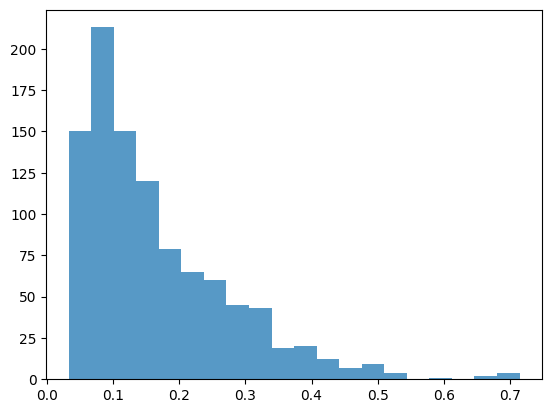

In [48]:
import math
### 遍历所有的数据集
index = 14070
counts = 2000
updata_list = []

for i in range(counts):
    up_data = dataset[i][1]
    if up_data[index] != 0:
        updata_list.append(math.fabs(up_data[index]))
    # break

import matplotlib.pyplot as plt
### 画一个频次图
plt.hist(updata_list, bins=20, alpha=0.75, log=False)
# plt.plot(updata_list)


(array([  43.,    0.,    0.,    0.,    6.,    7.,   30.,   40.,   63.,
          76.,  111.,  142.,  168.,  213.,  307.,  386.,  499.,  638.,
         711.,  853.,  912., 1005.,  989.,  953.,  897.,  788.,  688.,
         524.,  372.,  309.,  195.,  158.,   83.,   41.,   14.,   15.,
          18.,    5.,    0.,    3.]),
 array([0.00754166, 0.08264608, 0.15775051, 0.23285494, 0.30795937,
        0.38306379, 0.45816822, 0.53327265, 0.60837708, 0.6834815 ,
        0.75858593, 0.83369036, 0.90879478, 0.98389921, 1.05900364,
        1.13410807, 1.20921249, 1.28431692, 1.35942135, 1.43452578,
        1.5096302 , 1.58473463, 1.65983906, 1.73494349, 1.81004791,
        1.88515234, 1.96025677, 2.03536119, 2.11046562, 2.18557005,
        2.26067448, 2.3357789 , 2.41088333, 2.48598776, 2.56109219,
        2.63619661, 2.71130104, 2.78640547, 2.8615099 , 2.93661432,
        3.01171875]),
 <BarContainer object of 40 artists>)

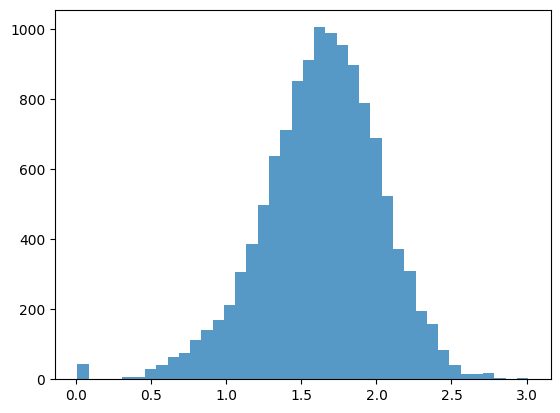

In [14]:
import math
### 遍历所有的数据集
index = 7048
counts = 12263
updata_list = []

for i in range(1,counts):
    up_data = dataset[i][1]
    updata_list.append(math.fabs(up_data[index]))
    # break

import matplotlib.pyplot as plt
### 画一个频次图
plt.hist(updata_list, bins=40, alpha=0.75)
# plt.plot(updata_list)


## 稀疏预测器

In [11]:
class SimpleLinearModel(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim=32):
        super(SimpleLinearModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim,bias=False)
        # self.activation = nn.SiLU() # 添加激活函数
        self.linear2 = nn.Linear(hidden_dim,output_dim,bias=False)  
        init.kaiming_normal_(self.linear1.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.linear2.weight, mode='fan_out', nonlinearity='relu')
        # self.linear1.bias.data.fill_(0)
        # self.linear2.bias.data.fill_(0)

    def forward(self, x):
        # x= self.activation(x)
        return self.linear2(self.linear1(x))
    
model=SimpleLinearModel(4096,14336,hidden_dim=1024)
model.to("cuda")  # 假设使用 GPU
# criterion = nn.MSELoss().to("cuda")
criterion = nn.CrossEntropyLoss().to("cuda")
# criterion = nn.KLDivLoss(reduction='batchmean').to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4) #lr=5e-5
writer = SummaryWriter('runs/predictor_sparsity')

In [12]:
from tqdm import tqdm

cnt = 0

def sparse_row(row, keep_ratio=0.1, use_abs = False):
    # 计算需要保留的参数数量
    num_to_keep = int(keep_ratio * row.numel())
    
    # 找到绝对值最大的 num_to_keep 个参数的索引
    if use_abs:
        row = torch.abs(row)
    topk_indices = torch.topk(row, num_to_keep).indices
    # topk_indices = torch.topk(row, num_to_keep).indices
    
    # 创建一个与 row 相同大小的零张量
    sparse_row = torch.zeros_like(row)
    
    # 将 topk_indices 对应的值置为 1
    sparse_row[topk_indices] = 1
    
    return sparse_row

def generate_label(y, sparsity, use_abs=False):
    # 对每一行进行稀疏化
    sparse_tensor = torch.stack([sparse_row(row, sparsity, use_abs) for row in y])
    return sparse_tensor

def test_model(model, val_loader, sparsity=0.1):
    model.eval()
    # 初始化总的统计变量
    total_correct_preds = 0
    total_preds = 0
    total_labels = 0
    total_masks = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(enumerate(val_loader)):
            with autocast():
                outputs = model(inputs)

            preds = generate_label(outputs, sparsity)
            truth = generate_label(targets, 0.1, use_abs = True)
            # truth = targets
            
            # 计算当前batch的精度
            dif = truth - preds
            miss = dif > 0.0 # classifier didn't activated target neuron

            total_correct_preds += (truth.sum(dim=1).float() - miss.sum(dim=1).float()).mean().item()
            total_preds += (preds.sum(dim=1).float()).mean().item()
            total_labels += (truth.sum(dim=1).float()).mean().item()

    # print('预测占比:{:.4f}'.format((total_preds/total_masks).item()))
    # print('标签占比:{:.4f}'.format((total_labels/total_masks).item()))
    print('预测与标签选取的数量比:',(total_preds / total_labels))
    print('覆盖率(Recall):',(total_correct_preds / total_labels))

def train_model(model, train_loader, val_loader, criterion, optimizer, writer, epochs=25, layerid=1):
    scaler = GradScaler()  # 创建 GradScaler 对象
    for epoch in range(epochs):
        if epoch % 2 == 0:
            print(f'---------after training {epoch} epochs---------')
            test_model(model, val_loader, sparsity=0.2)
        model.train()
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()

            targets = generate_label(targets, 0.2, use_abs =True)

            # 使用 autocast 来进行自动混合精度处理
            with autocast():
                outputs = model(inputs)
                probs = outputs.sigmoid()
                # cross_entropy
                loss = criterion(probs, targets)

            # 使用 GradScaler 来缩放损失，然后进行反向传播
            # 注意：反向传播不包含在 autocast() 块中
            scaler.scale(loss).backward()
            writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_loader) + batch_idx)
            # 调用 scaler.step() 来更新模型权重，并调用 scaler.update() 准备下一步
            scaler.step(optimizer)
            scaler.update()
    print(f'---------after training {epochs} epochs---------')
    test_model(model, val_loader, sparsity=0.2)
    global cnt
    torch.save(model.state_dict(), f'./output/sparsity/{layerid}-{cnt}.pt')
    cnt += 1


In [4]:
for startid, endid in [(1,4),(4,7),(7,10)]:
    layerid = 15
    dataset = CustomDataset(layerid, startid=startid, endid=endid)
    print(len(dataset), dataset[0][0].shape, dataset[0][1].shape) # torch.Size([512, 4096])
    # 划分训练集和验证集
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

    train_model(model, train_loader, val_loader, criterion, optimizer, writer=writer, epochs=4, layerid=15)

333186 333186
333186 torch.Size([4096]) torch.Size([14336])
---------after training 0 epochs---------


33it [00:08,  3.91it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.20009789296144784
---------after training 2 epochs---------


33it [00:07,  4.16it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5413863739824867
---------after training 4 epochs---------


33it [00:08,  4.11it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5608398667241754
327227 327227
327227 torch.Size([4096]) torch.Size([14336])
---------after training 0 epochs---------


32it [00:07,  4.11it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5442518565676384
---------after training 2 epochs---------


32it [00:07,  4.15it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5660076314389747
---------after training 4 epochs---------


32it [00:07,  4.22it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5710160334627693
341549 341549
341549 torch.Size([4096]) torch.Size([14336])
---------after training 0 epochs---------


34it [00:08,  4.14it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5556886096016526
---------after training 2 epochs---------


34it [00:08,  4.22it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5726461708435582
---------after training 4 epochs---------


34it [00:08,  4.20it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5752094106414646


### 加载训练好的进行测试

In [13]:
layerid = 15
dataset = CustomDataset(layerid, startid=1, endid=4)
print(len(dataset), dataset[0][0].shape, dataset[0][1].shape) # torch.Size([512, 4096])
# 划分训练集和验证集
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
# model = SimpleLinearModel(4096,14336,hidden_dim=1024).cuda()
model.load_state_dict(torch.load(f'./output/sparsity/15-2.pt'))
test_model(model, val_loader, sparsity=0.3)

333186 333186
333186 torch.Size([4096]) torch.Size([14336])


33it [00:09,  3.30it/s]

预测与标签选取的数量比: 3.0006978367062107
覆盖率(Recall): 0.6927953512494317


### 下游任务测试

In [1]:
# Test Model
import os
import json
import torch
from transformers import LlamaForCausalLM, AutoTokenizer
from convert_llama import convert_llama_model
os.environ["HF_ENDPOINT"]="https://hf-mirror.com"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from lm_eval.models.huggingface import HFLM
from lm_eval import evaluator


def _load_model(model_name = "Llama3-8b"):
    print(f"Loading model {model_name}")
    ### from path.json read paths of model and dataset
    with open('path.json', 'r') as file:
        paths = json.load(file)
        model_path = paths.get(model_name, '')

    model = LlamaForCausalLM.from_pretrained(
        model_path,
        device_map='auto',
        use_cache=True,
        torch_dtype=torch.float16,
    )
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    return model, tokenizer

def evaluate(task_name, model, tokenizer, num_fewshot, device):
    hflm = HFLM(pretrained=model, tokenizer=tokenizer)
    results = evaluator.simple_evaluate(
    model=hflm,
    tasks=[task_name],
    num_fewshot=num_fewshot)
    print(results['results'])


def main(task_name, model_name, sparsity, start_num, end_num, token_sparsity, memory_limit, device, num_fewshot,):
    model, tokenizer = _load_model(model_name)
    
    model = convert_llama_model(model, sparsity, start_num, end_num, token_sparsity,)

    evaluate(task_name, model, tokenizer, num_fewshot, device)

main(task_name='boolq', model_name="Llama3-8b", sparsity=0.1, start_num=21, end_num=32, token_sparsity=0.1, memory_limit=0.1, device='cuda', num_fewshot=1)

KeyboardInterrupt: 